In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [3]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [27]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 425M/429M [00:13<00:00, 15.9MB/s]
100% 429M/429M [00:14<00:00, 32.1MB/s]


In [28]:
! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

 91% 98.0M/107M [00:03<00:00, 25.5MB/s]
100% 107M/107M [00:03<00:00, 28.6MB/s] 


In [29]:
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

100% 427M/428M [00:12<00:00, 56.9MB/s]
100% 428M/428M [00:12<00:00, 35.3MB/s]


In [30]:
! kaggle datasets download -d ejlok1/cremad

 99% 447M/451M [00:15<00:00, 30.3MB/s]
100% 451M/451M [00:15<00:00, 30.0MB/s]


In [31]:
!unzip \*.zip  && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: AudioWAV/1031_IEO_NEU_XX.wav  
  inflating: AudioWAV/1031_IEO_SAD_HI.wav  
  inflating: AudioWAV/1031_IEO_SAD_LO.wav  
  inflating: AudioWAV/1031_IEO_SAD_MD.wav  
  inflating: AudioWAV/1031_IOM_ANG_XX.wav  
  inflating: AudioWAV/1031_IOM_DIS_XX.wav 

In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
TESS = "/content/drive/MyDrive/kaggle/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/content/drive/MyDrive/kaggle/audio_speech_actors_01-24/"
SAVEE = "/content/drive/MyDrive/kaggle/ALL/"
CREMA = "/content/drive/MyDrive/kaggle/AudioWAV/"

# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a13.wav', 'DC_a08.wav', 'DC_a07.wav', 'DC_a05.wav']

In [6]:
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_happy        60
male_angry        60
male_surprise     60
male_sad          60
male_fear         60
male_disgust      60
Name: labels, dtype: int64

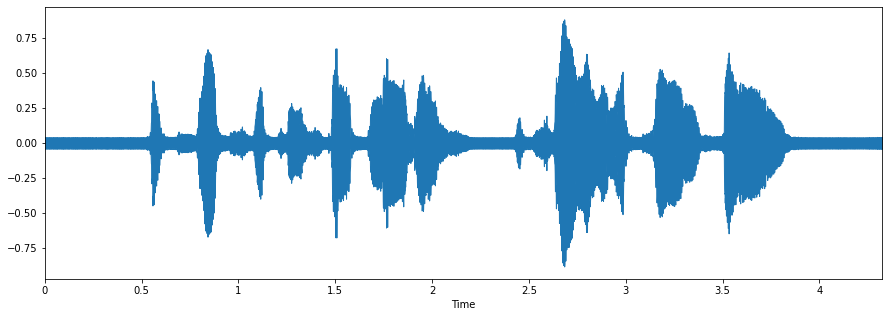

In [21]:
fname = SAVEE + 'DC_f11.wav' 
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [7]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_sad          96
female_disgust      96
male_angry          96
female_surprise     96
male_fear           96
male_disgust        96
female_angry        96
male_surprise       96
male_happy          96
female_fear         96
male_sad            96
female_happy        96
Name: labels, dtype: int64

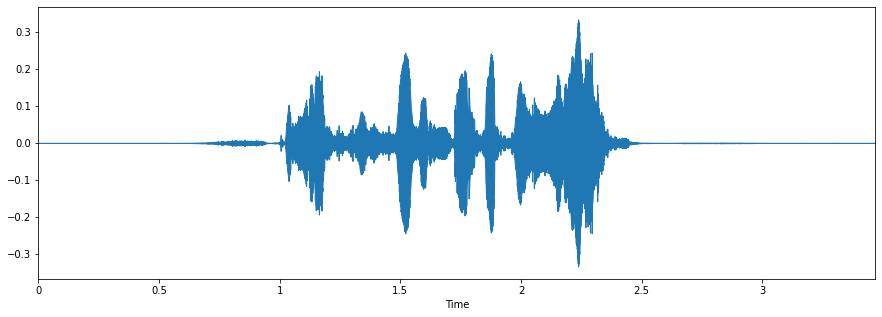

In [10]:
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

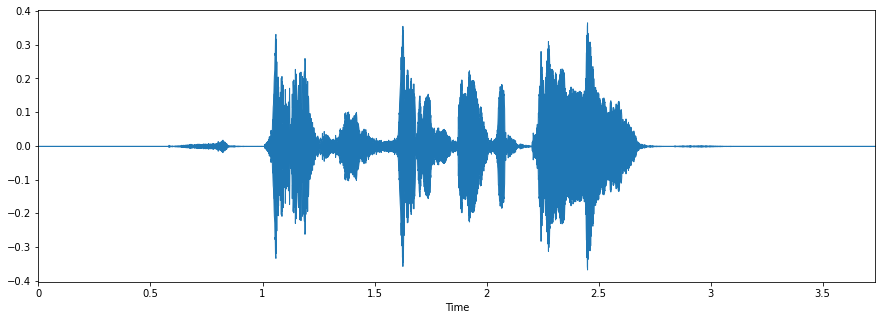

In [11]:
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [8]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [9]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_sad         400
female_happy       400
female_fear        400
female_surprise    400
female_neutral     400
female_disgust     400
female_angry       400
Name: labels, dtype: int64

In [10]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [12]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_fear         671
male_disgust      671
male_sad          671
male_angry        671
male_happy        671
female_sad        600
female_happy      600
female_disgust    600
female_angry      600
female_fear       600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_sad         1096
female_happy       1096
female_disgust     1096
female_angry       1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_disgust        827
male_happy          827
male_fear           827
male_sad            827
male_angry          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64
